# Segmentation with PyTorch

For this particular project, we will generate a [synthetic dataset](https://github.com/Mostafa-wael/U-Net-in-PyTorch/blob/main/test.py) to train and validate our model in segmenting various geometric figures. The model will assign distinct colors to the pixels of each figure type. For instance, squares will be colored yellow, circles will be colored red, and so forth. To create the random data, download the **simulations** folder from the *data* directory and **place it in the same folder as your notebook** as follows:

```
    notebooks/ 
        03_segmentation.ipynb
        simulations/
            __init__.py
            simpleImages.py
            utils.py
        

```

| <span style="font-size:15px">**Step** | <span style="font-size:15px">**Description** |
| :-----| :----- |
| <span style="font-size:15px">**1. Data preprocessing** |<span style="font-size:14px"> Prepare your dataset to be processed by the model. |
| <span style="font-size:15px">**2. Building a model** |<span style="font-size:14px"> Design an appropriate model architecture that suits your problem domain. | 
|<span style="font-size:15px"> **3. Fitting the model to data** |<span style="font-size:14px"> Select a loss function, optimizer and build a training loop.|
| <span style="font-size:15px">**4. Visualize model predictions** |<span style="font-size:14px"> Compare the ground truth and the model's results |

# 0. Getting setup
### Importing necessary libraries and modules

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torchvision import transforms as torchTransforms
from torch.utils.data import Dataset, DataLoader

import simulations.simpleImages as simulation
from simulations.simpleImages import generate_random_data
import simulations.utils as utils
from typing import Tuple, Dict, List
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from random import randint
import os

### Set device

Setup device-agnostic code for our models and data to run on GPU if it's available.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Data preprocessing

## 1.1 Analyze the dataset by checking the images' resolution and visualizing a single sample.

In [3]:
N = 1 # Set the number of samples to be generated
M = 128 # Set the size of the images (M x M pixels)

# Generate random input images and corresponding target masks
input_images, target_masks = simulation.generate_random_data(M, M, count = N)

# Extract the shape of the input_images and samples
n_samples, x_size, y_size, n_channels = input_images.shape
n_samples, n_masks, x_size, y_size = target_masks.shape

print(input_images.shape)
print(target_masks.shape)

(1, 128, 128, 3)
(1, 6, 128, 128)


>**input_images**: (1, M, M, C) - A single image with MxM resolution and C channels.

>**target_masks**: (1, N, M, M) - A single image with N masks, each of size MxM.

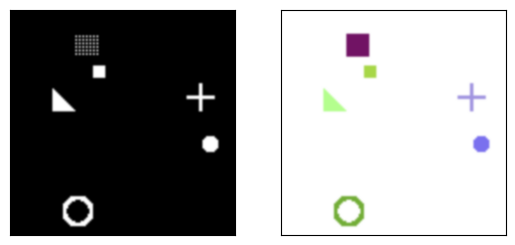

In [4]:
# Change channel-order and make 3 channels for matplot 
input_images_rgb = list(input_images.astype(np.uint8))

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]

simulation.show_images_samples(input_images_rgb, target_masks_rgb)

### 1.2 Create the dataset class

In [5]:
class SimDataset(Dataset):
    '''
        Pytorch Dataset of random synthetic simple images. This dataset contains simple 
        images with six figures (filled square, mesh square, circle, triangle...).

        Important: 
            dataset contains (H x W x C) in the range [0, 255], if you want to 
            use it like a tensor you have to convert the shape to C x H x W) in the range [0.0, 1.0].

            The easiest way is to apply torchvision.transform.ToTensor() indicating it in the initializer.
            Ej. SimDataset(X, tranform='torchvision.transform.ToTensor()')
    '''
    
    def __init__(self, count, transform = None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count = count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

### 1.3 Create dataset and dataloader

In [6]:
# Define a series of transformations to be applied
trans = torchTransforms.Compose([
            torchTransforms.ToTensor(),
            torchTransforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                      std = [0.229, 0.224, 0.225])
        ])

# Create the training and validation dataset
train_set = SimDataset(1200, transform = trans) 
val_set = SimDataset(120, transform = trans)
image_datasets = { 'train' : train_set, 'val' : val_set }

# Set the batch size 
batch_size = 8 

# Create the dataloaders 
dataloaders = {
    'train': DataLoader(train_set, batch_size = batch_size, shuffle = True),
    'val': DataLoader(val_set, batch_size = batch_size, shuffle = True)
}

# Calculate the sizes of the training and validation datasets and store them in a dictionary
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets.keys()}

# Print the sizes of the training and validation datasets
print('Dataset Sizes: {}'.format(dataset_sizes))

Dataset Sizes: {'train': 1200, 'val': 120}


# 1. Building the model

Let's begin by constructing the fundamental blocks that make up the UNet network.

### Convolutional + Relu block

In [7]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

### Encoder

In [8]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

### Decoder

In [9]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, 
                                     stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

After defining the building blocks of our architecture, we can proceed to construct the class responsible for implementing the U-Net network.

### U-Net class

In [10]:
class UNet(nn.Module):
    def __init__(self, output_channels, input_channels = 3):
        super().__init__()
        # Encoder
        self.e1 = encoder_block(input_channels, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        
        # Bottleneck
        self.b = conv_block(512, 1024)
        
        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        
        # Output
        self.outputs = nn.Conv2d(64, output_channels, kernel_size = 1, padding = 0)
        
    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        # Bottleneck
        b = self.b(p4)
        
        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        return self.outputs(d4)

### Instantiate an instance of the UNet model

We will keep the default number of input channels (3) because we are working with RGB images. The number of output channels in the model corresponds to the number of expected masks. In this case, we require 6 output channels, each one corresponding to a geometric figure. With this setup, the model can assign a unique value or color mask to each shape."

- Filled_square
- Mesh_square
- Triangle
- Circle
- Circumference
- Plus

In [11]:
n_classes = 6

# Create an instance of the UNet model
model = UNet(output_channels = n_classes)
model = model.to(DEVICE)

# 3. Fitting the model to data

## 3.1 Build a training loop

In [12]:
def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))

In [13]:
def train_model(model, criterion, optimizer, model_path, num_epochs = 20):
   
    best_loss = 1e10
    
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            # Update results dictionary
            if phase == 'train':
                results["train_loss"].append(epoch_loss)

            
            elif phase == 'val':
                results["val_loss"].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), os.path.join(model_path))
                print('Model saved!')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print('Best val loss: {:4f}'.format(best_loss))

    return results

In [14]:
def plot_loss(results: Dict[str, List[float]]):
    
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"val_loss": [...],
             "val_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'train_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

## 3.2 Define the loss function and configure the optimizer

Implement a loss function tailored for training the model in our segmentation problem.

In [15]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

Create an Adam optimizer to update the model's parameters with a learning rate of 1e-4

In [16]:
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

## 3.3 Train the model 

We will perform a short 5-epoch training session as a quick demonstration, but feel free to experiment with different training durations to find the most suitable one.

In [17]:
MODEL_PATH = '../data/models/UNet_GeometricFigures.pth'
model_results = train_model(model, calc_loss, optimizer, MODEL_PATH, num_epochs = 5)

Epoch 0/4
----------
train: bce: 0.130199, dice: 0.787050, loss: 0.458624
val: bce: 0.021372, dice: 0.539270, loss: 0.280321
Model saved!
Epoch 1/4
----------
train: bce: 0.018707, dice: 0.417557, loss: 0.218132
val: bce: 0.014112, dice: 0.363469, loss: 0.188790
Model saved!
Epoch 2/4
----------
train: bce: 0.013313, dice: 0.319149, loss: 0.166231
val: bce: 0.011011, dice: 0.287768, loss: 0.149390
Model saved!
Epoch 3/4
----------
train: bce: 0.010780, dice: 0.244276, loss: 0.127528
val: bce: 0.010325, dice: 0.219048, loss: 0.114687
Model saved!
Epoch 4/4
----------
train: bce: 0.009200, dice: 0.150871, loss: 0.080036
val: bce: 0.008922, dice: 0.114580, loss: 0.061751
Model saved!
Training complete in 1m 16s
Best val loss: 0.061751


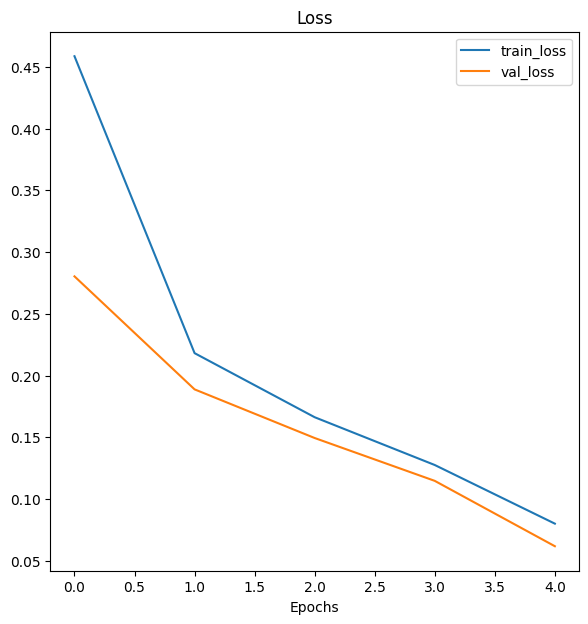

In [18]:
plot_loss(model_results)

## 4 Visualize model predictions on images from the test set

## 4.1 Prepare the test dataset

Define the transforms

In [19]:
trans = torchTransforms.Compose([
            torchTransforms.ToTensor(),
            torchTransforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])

Create test dataset and dataloader

In [20]:
# Generate 24 random samples for the test dataset
batch_size = 8
test_set = SimDataset(24, transform = trans)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

## 4.2 Load your trained model

The model trained in this notebook can be loaded from the directory:

```
data/ 
    models/ 
        UNet_GeometricFigures.pth
```

In [21]:
# Load the U-Net architecture
n_classes = 6
model = UNet(output_channels = n_classes)

# Move the model to the specified device
model.to(DEVICE)

# Load trained weights
MODEL_PATH = '../data/models/UNet_GeometricFigures.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

<All keys matched successfully>

## 4.3 Build a testing loop

In [22]:
# Initialize empty lists 
predictions = []
img = []
targets = []

# Perform inference on the test_loader
with torch.no_grad():
    for inputs, labels in test_loader:
        
        # Perform inference on the test_loader 
        inputs = inputs.to(DEVICE)
        pred = model(inputs)
        
        # Append the input images,labels and predictions to their respective lists
        img.append(inputs.cpu())
        targets.append(labels.cpu())
        predictions.append(pred.cpu())
        
# Empty the GPU cache to release memory       
torch.cuda.empty_cache()

## 4.4 Compare the ground truth and the model's results.

Specify appropriate functions to ensure accurate visualization of the targets and model predictions.

In [23]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

In [24]:
# Select the first batch (0)
inputs = img[0]
labels = targets[0]
pred = predictions[0]

# Ensure the predicted masks' values are within the range [0, 1]
pred = torch.sigmoid(pred) 

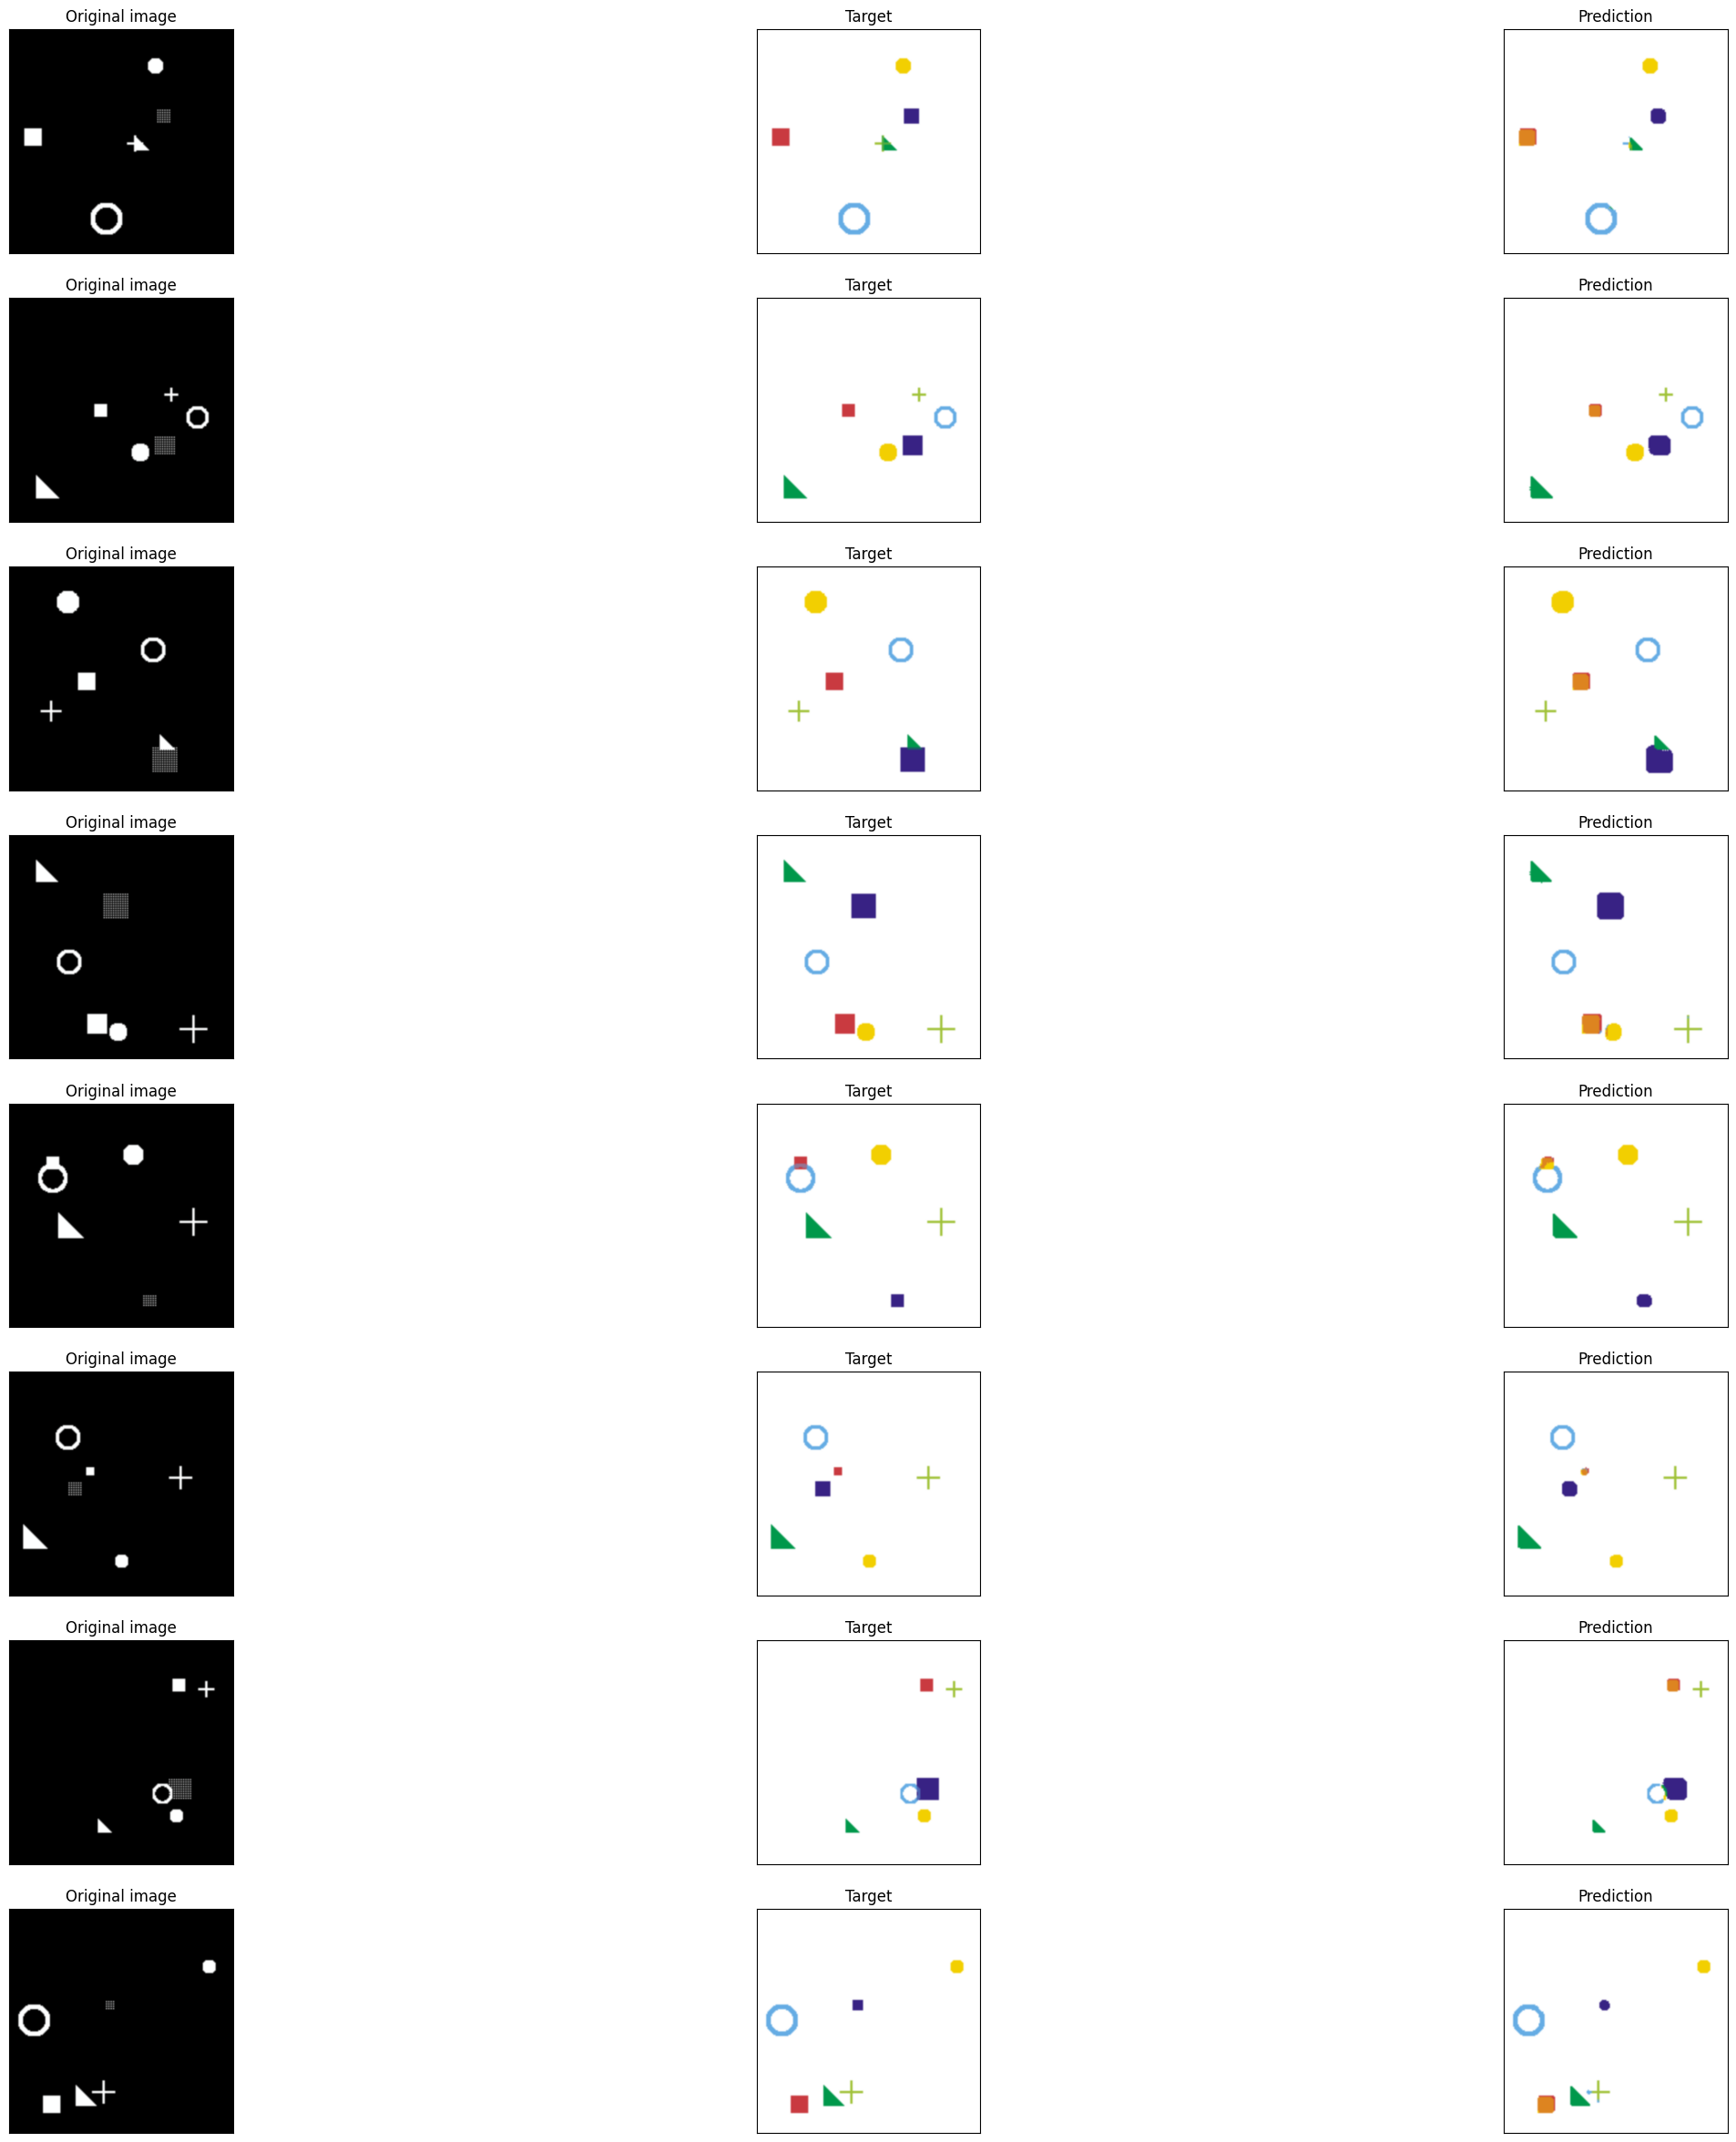

In [25]:
plt.rcParams['figure.figsize'] = [30, 30]

input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred.cpu().detach().numpy()]

nSamples = len(input_images_rgb)
images = [None]*(3*nSamples)
images[::3] = input_images_rgb
images[1::3] = target_masks_rgb
images[2::3] = pred_rgb

titles = ['Original image', 'Target', 'Prediction'] *nSamples

utils.show_images(images, titles, nRow = nSamples, nCol=3)

As we can see, the predictions of the model are very similar to the desired outputs (targets), although if we observe closely, we can notice some imprecisions. In the case of segmentation, it is useful to visualize the model's results and compare these outputs with the ground truth.